# IMPORTS

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.morphology import medial_axis
from skimage import img_as_ubyte
from  scipy import ndimage
from keras.models import load_model
from skimage.morphology import medial_axis, label
import math
from skimage.measure import label, regionprops
import random

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from skimage.transform import resize
from patchify import patchify, unpatchify

# UTILS

## Color mask

In [ ]:
def mask_coloring_v2(mask, pixel_value, target_value):
  color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  color_mask[mask == pixel_value, :] = target_value
  return color_mask

## Predict high res photo

In [ ]:
def predict_high_res(image, model):
  patches_img = patchify(image, (256,256,3), step=256)

  predicted_patches = []
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch = patches_img[i,j,0,:,:,]
      single_patch_input=np.expand_dims(single_patch, 0)
      prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
      predicted_patches.append(prediction)

  predicted_patches = np.array(predicted_patches)
  predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], 256,256))
  reconstructed_image = unpatchify(predicted_patches_reshaped, (img_resized.shape[0], img_resized.shape[1]))

  return reconstructed_image

## Resize image

In [ ]:
def resize_im(large_im):
  height = math.floor(large_im.shape[0]/256) *256
  width = math.floor(large_im.shape[1]/256)  *256
  resized = resize(large_im, (height, width))
  return resized

## Remove noise

In [ ]:
def remove_noise_for_plot(im):
  width, height = im.shape
  for i in range(width):
      for j in range(height):
        # if i < 790 or i > 2810:
        if i < 790 or i > 2610 or j>3700:
          im[i, j] = 0

  return im

## Random RGB value

In [ ]:
def random_rgb():
  color = list(np.random.choice(range(256), size=3))
  return color

# LOAD IMAGES

In [ ]:
!wget -O tekieli.zip https://www.dropbox.com/s/s9zgark5r26na57/tekieli.zip?dl=0
!unzip /content/tekieli.zip

images_dir_path = "/content/selected_image"
masks_dir_path =  "/content/selected_mask"

## Image dataset

In [ ]:
image_names = glob.glob(f"{images_dir_path}/*.jpg")
image_names.sort()


image_dataset_tekieli = []   

for image_name in image_names: 
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset_tekieli.append(np.array(image))

In [ ]:
image_dataset_stack =  np.array(image_dataset_tekieli)
image_dataset_stack.shape

(6, 4000, 6000, 3)

## Mask dataset

In [ ]:
mask_names = glob.glob(f"{masks_dir_path}/*.png")
mask_names.sort()

mask_dataset_tekieli = [] 

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = image / 255
        image = Image.fromarray(image)
        mask_dataset_tekieli.append(np.array(image))

In [ ]:
mask_dataset_stack = np.array(mask_dataset_tekieli)
mask_dataset_stack.shape

(6, 4000, 6000)

# LOAD MODELS

In [ ]:
!pip install keras_unet_collection
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from keras_unet_collection.activations import GELU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 6.5 MB/s 


In [ ]:
#U-Net

# BEST MODELS
from tensorflow.keras import backend as K
#U-Net
unet_path = "/content/gdrive/MyDrive/25may/unet.epoch23-dice_coef0.85.hdf5"
unet_model = load_model(unet_path, compile=False)

#Attention U-Net 
att_unet_path = "/content/gdrive/MyDrive/25may/att_unet.epoch33-dice_coef0.83.hdf5" 
att_unet_model = load_model(att_unet_path, compile=False)

#Trans U-Net 
transunet_path = "/content/gdrive/MyDrive/25may/trans_unet.epoch38-dice_coef0.85.hdf5"
transunet_model = load_model(transunet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

# TEKIELI U-Net
tekieli_unet_path = "/content/gdrive/MyDrive/tekieli/unet.epoch100-dice_coef0.85.hdf5"
tekieli_unet_model = load_model(tekieli_unet_path, compile=False)

In [ ]:
models = {"unet": unet_model, 
          "att_unet":att_unet_model, 
          "trans_unet":transunet_model,
          "tekieli_unet": tekieli_unet_model
          }

# VISUALIZE IMAGE AND GROUND TRUTH



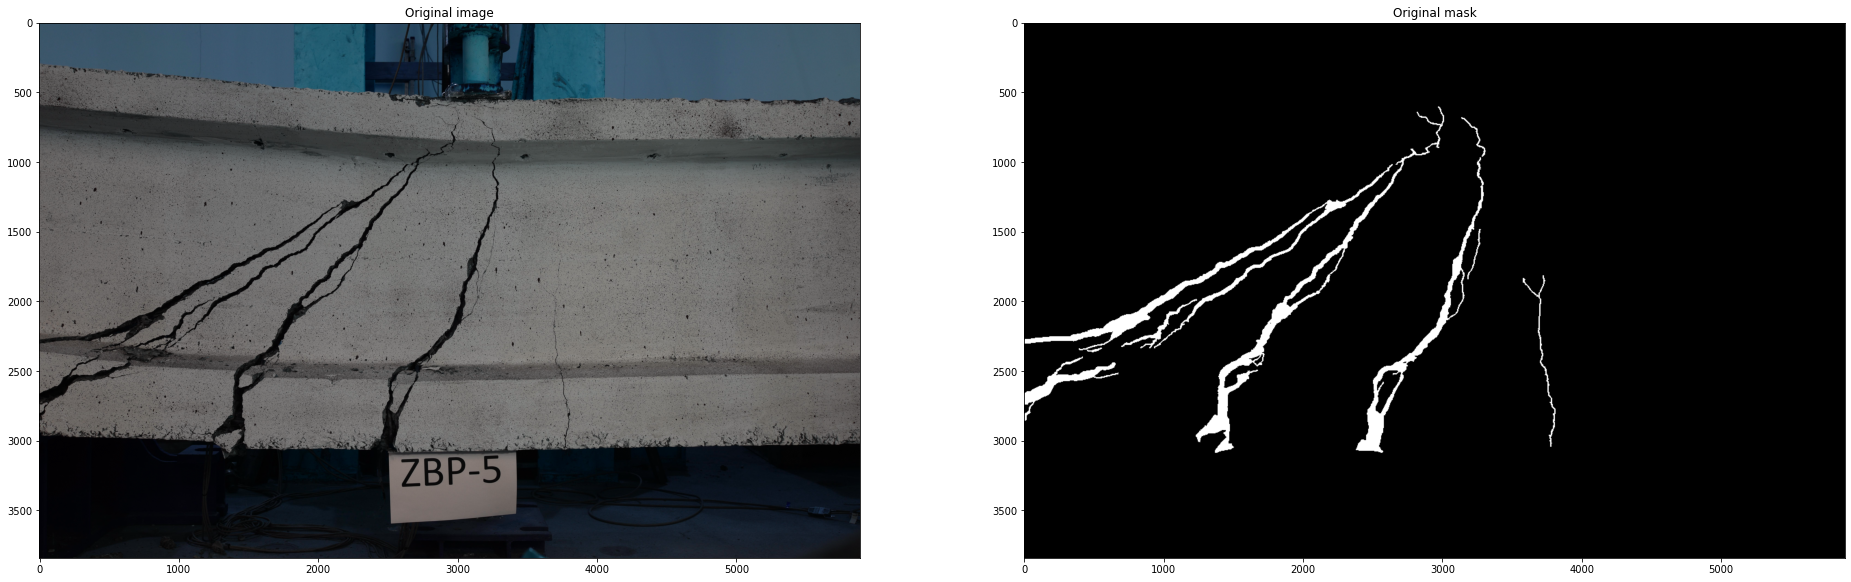

In [ ]:
img_resized = resize_im(image_dataset_stack[1])
mask_resized = resize_im(mask_dataset_stack[1])


plt.figure(figsize=(50, 50))
plt.subplot(231)
plt.title('Original image')
plt.imshow(img_resized, cmap='gray')
plt.subplot(232)
plt.title('Original mask')
plt.imshow(mask_resized, cmap='gray')

# PREDICT SINGLE 

In [ ]:
#unet
unet_prediction_tek = predict_high_res(img_resized, models["unet"])
#att unet
attunet_prediction_tek = predict_high_res(img_resized, models["att_unet"])
# transunet
transunet_prediction_tek = predict_high_res(img_resized, models["trans_unet"])
#unet tekieli fine-tuned
tekieli_unet_prediction = predict_high_res(img_resized, models["tekieli_unet"])

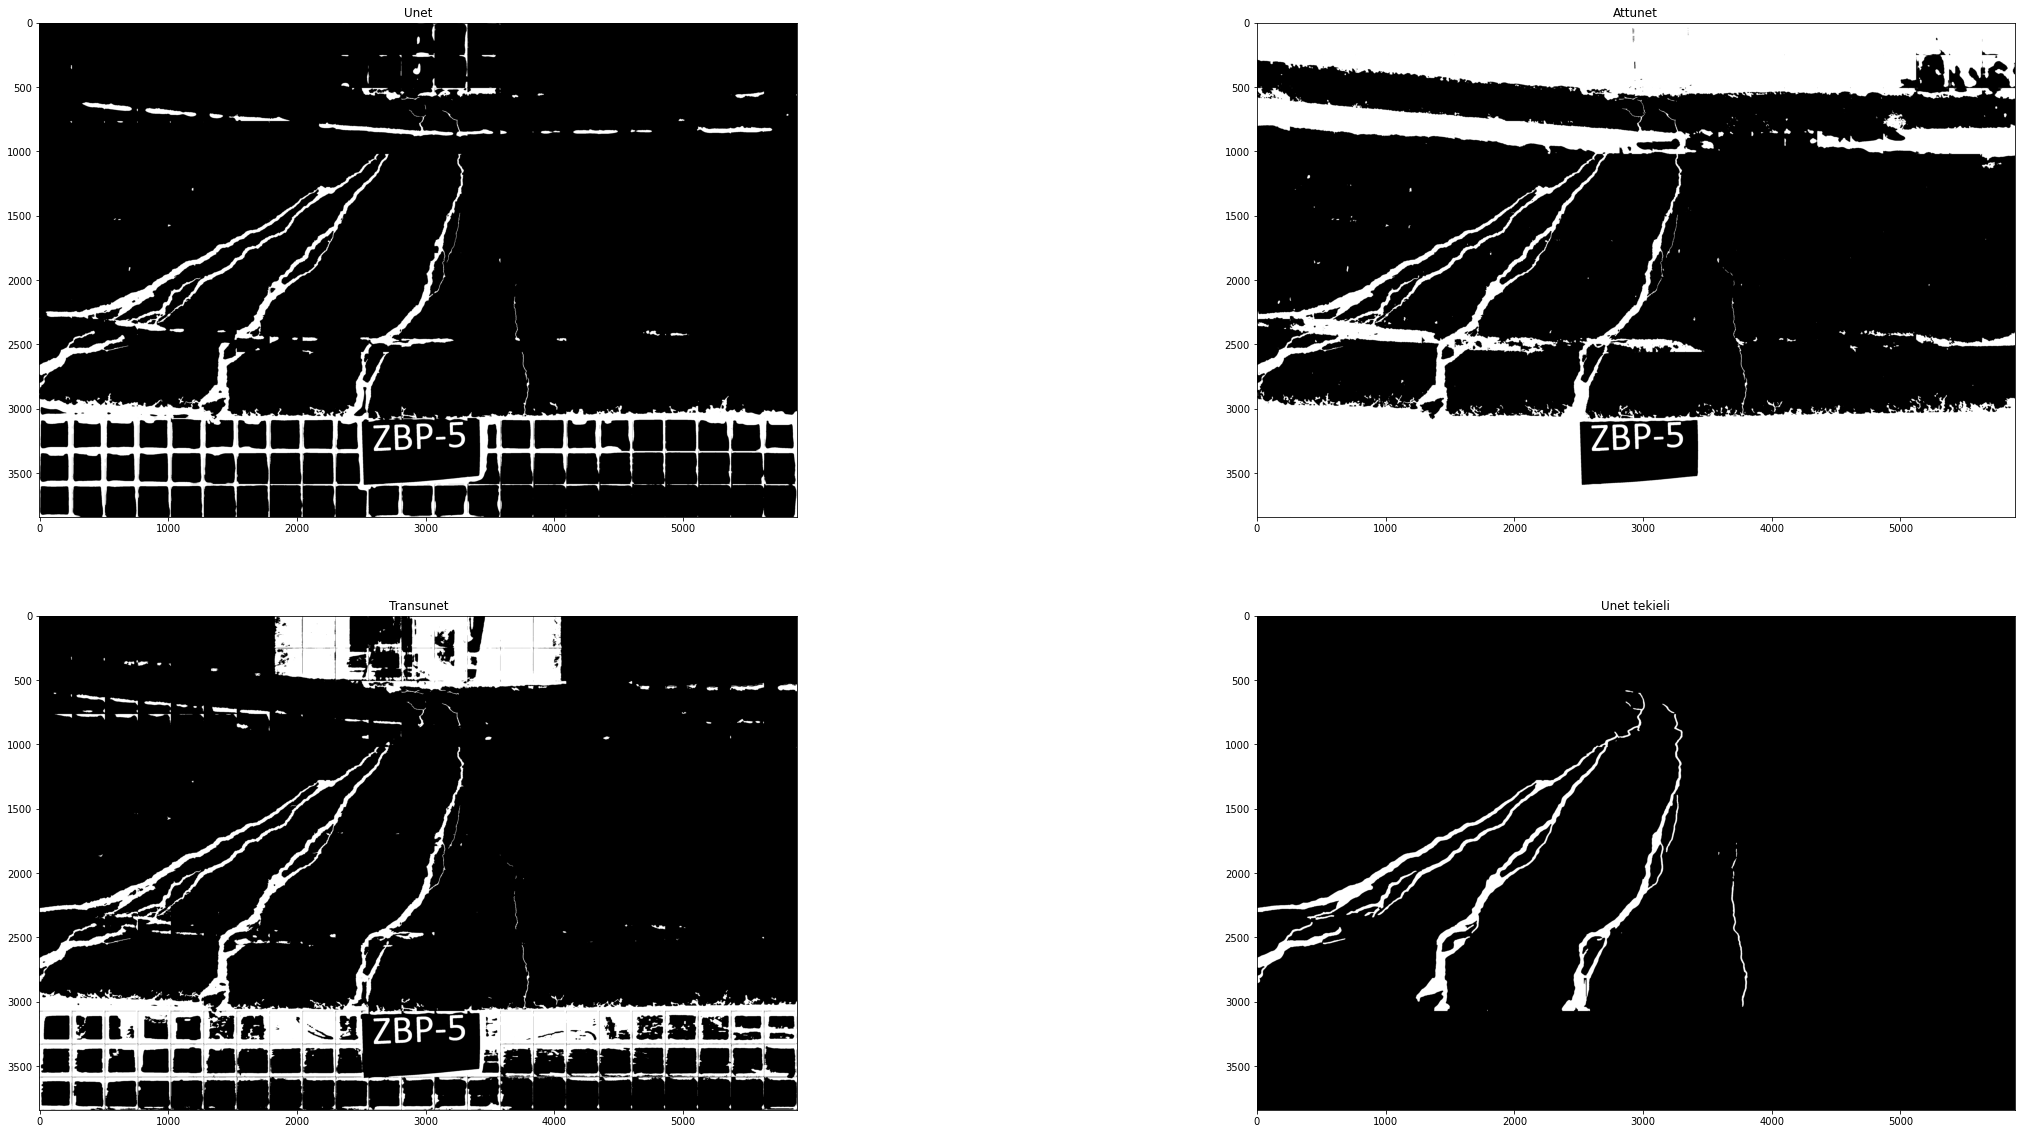

In [ ]:
plt.figure(figsize=(40, 20))
plt.subplot(221)
plt.title('Unet')
plt.imshow(unet_prediction_tek, cmap='gray')
plt.subplot(222)
plt.title('Attunet')
plt.imshow(attunet_prediction_tek, cmap='gray')
plt.subplot(223)
plt.title('Transunet')
plt.imshow(transunet_prediction_tek, cmap='gray')
plt.subplot(224)
plt.title('Unet tekieli')
plt.imshow(tekieli_unet_prediction, cmap='gray')

In [ ]:
def remove_noise_for_measure(im):
  width, height = im.shape
  for i in range(width):
      for j in range(height):
        # if i < 790 or i > 2810:
        if i < 900 or i > 2610 or j>3800:
          im[i, j] = 0
        if i > 2300 and i < 2340 and j>700 and j<2300:
          im[i, j] = 0
        if i > 2300 and i < 2340 and j>2600 and j<3450:
          im[i, j] = 0

  return im

# NOISE REMOVED

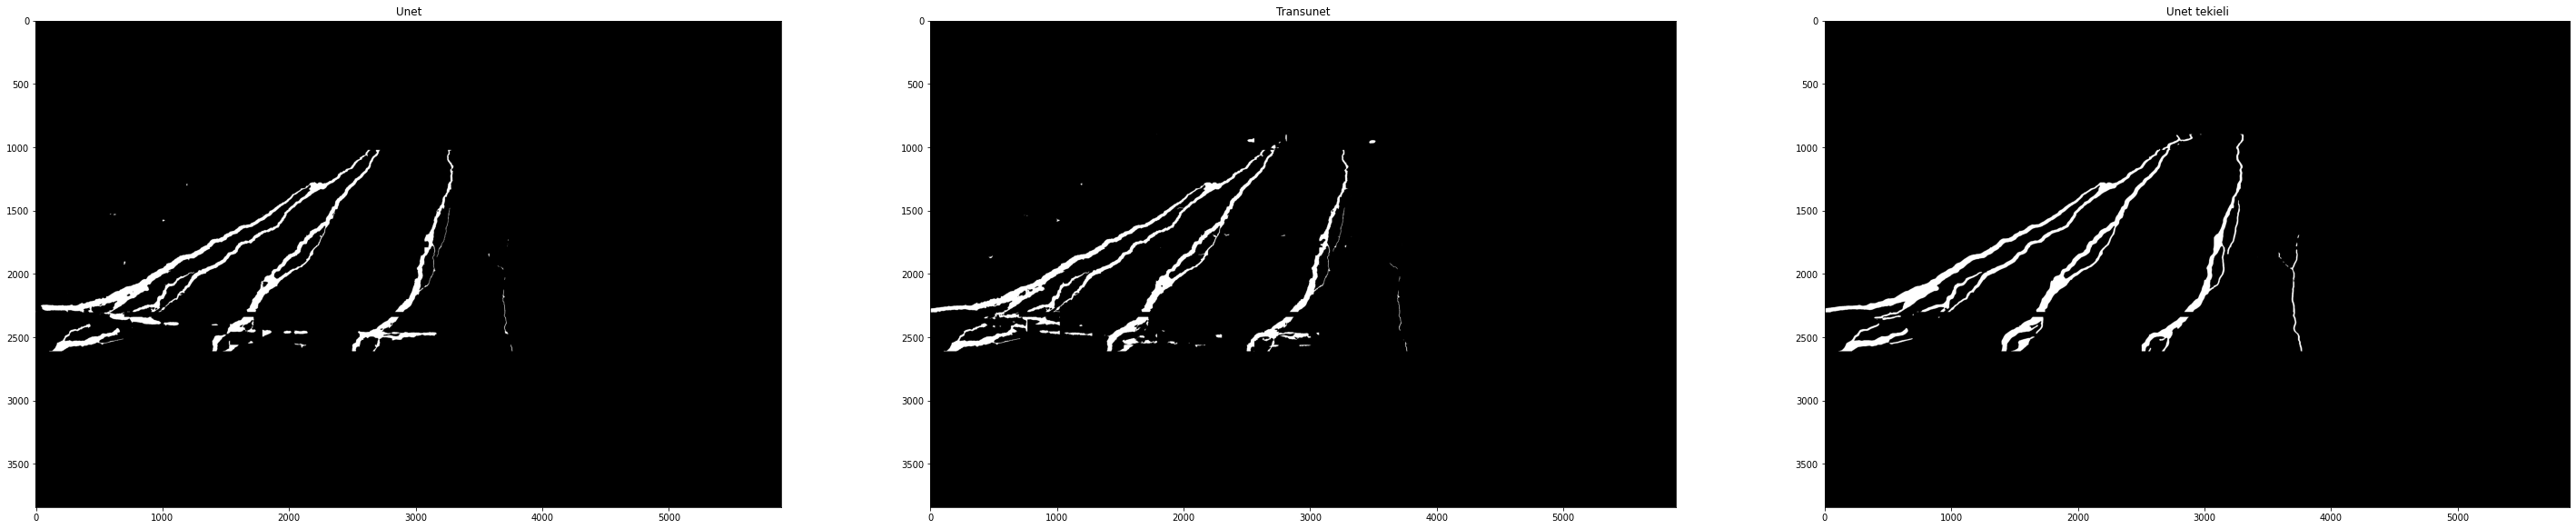

In [ ]:
unet_no_noise = remove_noise_for_measure(np.copy(unet_prediction_tek))
transunet_no_noise = remove_noise_for_measure(np.copy(transunet_prediction_tek))
tekieli_unet_no_noise = remove_noise_for_measure(np.copy(tekieli_unet_prediction))

plt.figure(figsize=(50, 50))
plt.subplot(131)
plt.title('Unet')
plt.imshow(unet_no_noise, cmap='gray')
plt.subplot(132)
plt.title('Transunet')
plt.imshow(transunet_no_noise, cmap='gray')
plt.subplot(133)
plt.title('Unet tekieli')
plt.imshow(tekieli_unet_no_noise, cmap='gray')

In [ ]:
def get_gray_crack_instances(im):
  labeled = label(im, background=0)
  props = regionprops(labeled)
  cracks = []

  for instance in props:
    label_number = instance["label"]
    instance_area = instance.area
    if instance_area > 500:
      crack_instance = np.zeros((im.shape[0],im.shape[1]), np.uint8)
      for i in range(im.shape[0]):
        for j in range(im.shape[1]):
          if labeled[i,j] == label_number:
            crack_instance[i,j] = label_number   

      cracks.append(crack_instance)

  return cracks

# MEASURE INSTANCES

## utils

In [ ]:
def get_boundary(image, rgb_value):

  im = image.astype(np.uint8) * 255
  _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)
  rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
  contour_plot_rgb = np.zeros((image.shape[0],image.shape[1],3), np.uint8)
  contour_rgb, _ = cv2.findContours(crack, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(contour_plot_rgb, contour_rgb, -1, rgb_value, 1)

  return contour_plot_rgb

In [ ]:
from skimage.measure import label, regionprops

def color_instaces(im):
  labeled = label(im, background=0)
  props = regionprops(labeled)

  cracks = []
  for i in np.unique(labeled):
    if i == 0:
      continue
    rgb = random_rgb()
    color_mask = mask_coloring_v2(labeled, i, rgb)
    cracks.append(color_mask)

  return cracks


In [ ]:
def get_gray_crack_instances(im):
  labeled = label(im, background=0)
  props = regionprops(labeled)
  cracks = []

  for pixel_value in np.unique(labeled):
    if pixel_value == 0:
      continue
    crack_instance = np.zeros((im.shape[0],im.shape[1]), np.uint8)
    for i in range(im.shape[0]):
      for j in range(im.shape[1]):
        if labeled[i,j] == pixel_value:
          crack_instance[i,j] = pixel_value

    cracks.append(crack_instance)

  return cracks

In [ ]:
def calculate_euclidean_distance(p1,p2):
  s1 = (math.pow(p1[0] - p2[0],2))
  s2 = (math.pow(p1[1] - p2[1],2))
  euclidean_distance = math.sqrt(s1+s2)
  return euclidean_distance

In [ ]:
from skimage.morphology import skeletonize
def measure_insatance(instance):

  rgb_original = cv2.cvtColor(instance, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose

  im = instance.astype(np.uint8) * 255
  rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  _, crack = cv2.threshold(im, 50 , 255, cv2.THRESH_BINARY)
  

  # get medial axis
  med_plot = np.zeros((instance.shape[0],instance.shape[1]), np.uint8)
  medial, distance = medial_axis(im, return_distance=True)
  med_img = img_as_ubyte(medial)
  med_contours, _ = cv2.findContours(med_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(med_plot, med_contours, -1, (255, 0, 0), 1)
  med_pts = [v[0] for v in med_contours[0]]

  # get point with maximal distance from medial axis
  max_idx = np.argmax(distance)
  max_pos = np.unravel_index(max_idx, distance.shape)
  max_dist = distance[max_pos]
  coords = np.array([max_pos[1], max_pos[0]])
  # print(f"max distance from medial axis to boundary = {max_dist} at x,y: {coords}")

  border_values = {0, 256}
  if coords[1] in border_values or coords[0] in border_values:
    pass

  # interpolate orthogonal of medial axis at coords
  delta = 150
  try:
    idx = next(i for i, v in enumerate(med_pts) if (v == coords).all())
    px1, py1 = med_pts[(idx-delta) % len(med_pts)]
    px2, py2 = med_pts[(idx+delta) % len(med_pts)]
    orth = np.array([py1 - py2, px2 - px1]) * max(im.shape)
    # intersect orthogonal with crack and get contour
    orth_img = np.zeros(im.shape, dtype=np.uint8)
    A = tuple(coords + orth)
    B = tuple(coords - orth)
    cv2.line(orth_img, A, B, color=255, thickness=1)
    gap_img = cv2.bitwise_and(orth_img, crack)

    gap_contours, _ = cv2.findContours(gap_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gap_pts = [v[0] for v in gap_contours[0]]

    if len(gap_pts) == 1:
      pass

    # determine the end points of the gap contour by negative dot product
    n = len(gap_pts)
    gap_ends = [
    p for i, p in enumerate(gap_pts)
    if np.dot(p - gap_pts[(i-1) % n], gap_pts[(i+1) % n] - p) < 0
    ]
    # print(f"Maximum gap found from {gap_ends[0]} to {gap_ends[1]}")

    C = tuple(gap_ends[0])
    D = tuple(gap_ends[1])
    distance = round(calculate_euclidean_distance(C,D),3)
  except:
    return [[0,0], 0]

  return [[C,D], distance]

In [ ]:
def crack_measurement(instance): 
  rgb_original = cv2.cvtColor(instance, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose

  crack_list = measure_insatance(instance)
  start = crack_list[0][0]
  end = crack_list[0][1]
  distance = crack_list[1]

  canvas = np.zeros((instance.shape[0],instance.shape[1],3), np.uint8)
  cv2.line(canvas, start, end, color=(255, 255, 255), thickness=6)
  text = str(distance) + "px"
  cv2.putText(canvas, text, (500, 500), cv2.FONT_HERSHEY_SIMPLEX, 6, (255, 0, 0), 4, cv2.LINE_AA)

  pixel_value = np.unique(instance)[-1]
  rgb_value = random_rgb()
  color_mask = np.zeros((instance.shape[0], instance.shape[1], 3), dtype=np.uint8)
  color_mask[instance == pixel_value, :] = rgb_value

  blended = cv2.addWeighted(color_mask, 1, canvas, 1, 0)

  plt.figure(figsize=(25, 15))
  plt.imshow(blended)
  # return rgb_original

In [ ]:
def get_crack_lines(image):
  
  grayscale_instances = get_gray_crack_instances(image)
  filtered_crack_instances = []
  for i in grayscale_instances:
    inst = measure_insatance(i)
    if inst[1] != 0:
      filtered_crack_instances.append(inst)

  canvas = np.zeros((tekieli_unet_no_noise.shape[0],tekieli_unet_no_noise.shape[1],3), np.uint8)
  for coords, dist in filtered_crack_instances:
    start = coords[0]
    end = coords[1]
    cv2.line(canvas, start, end, color=(255, 0, 0), thickness=10)
    text = str(dist) + "px"
    text_placement = (start[0] + 50, start[1]+50)
    cv2.putText(canvas, text, text_placement, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)

  return canvas

In [ ]:
def get_crack_lines(image):
  
  grayscale_instances = get_gray_crack_instances(image)
  filtered_crack_instances = []
  for i in grayscale_instances:
    inst = measure_insatance(i)
    if inst[1] != 0:
      filtered_crack_instances.append(inst)

  return filtered_crack_instances

In [ ]:
def put_text(filtered_crack_instances):
  canvas = np.zeros((tekieli_unet_no_noise.shape[0],tekieli_unet_no_noise.shape[1],3), np.uint8)
  for coords, dist in filtered_crack_instances:
    start = coords[0]
    end = coords[1]
    cv2.line(canvas, start, end, color=(255, 0, 0), thickness=10)
    text = str(dist) + "px"
    text_placement = (start[0] + 20, start[1]+20)
    cv2.putText(canvas, text, text_placement, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2, cv2.LINE_AA)

  return canvas

In [ ]:
def blend_crackline_w_mask(crack_canvas, mask, mask_opacity, crack_opacity):
  rgb = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  blended = cv2.addWeighted(rgb, mask_opacity, crack_canvas, crack_opacity,0)

  return blended

## TEKIELI UNET

In [ ]:
IMAGE_TO_PLOT = tekieli_unet_no_noise
image_copy = np.copy(IMAGE_TO_PLOT)

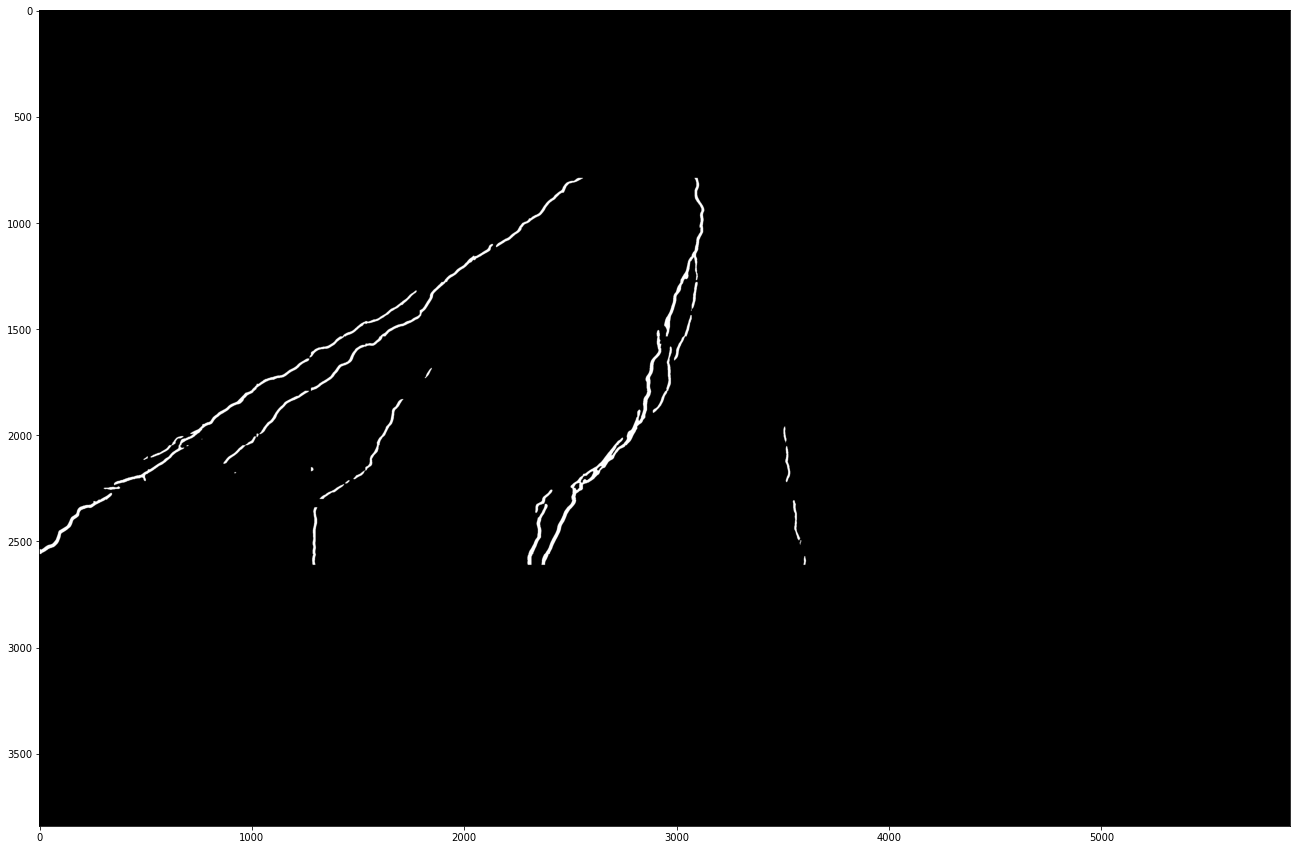

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(IMAGE_TO_PLOT, cmap="gray")


# plt.savefig("cracklines_with_text.png")

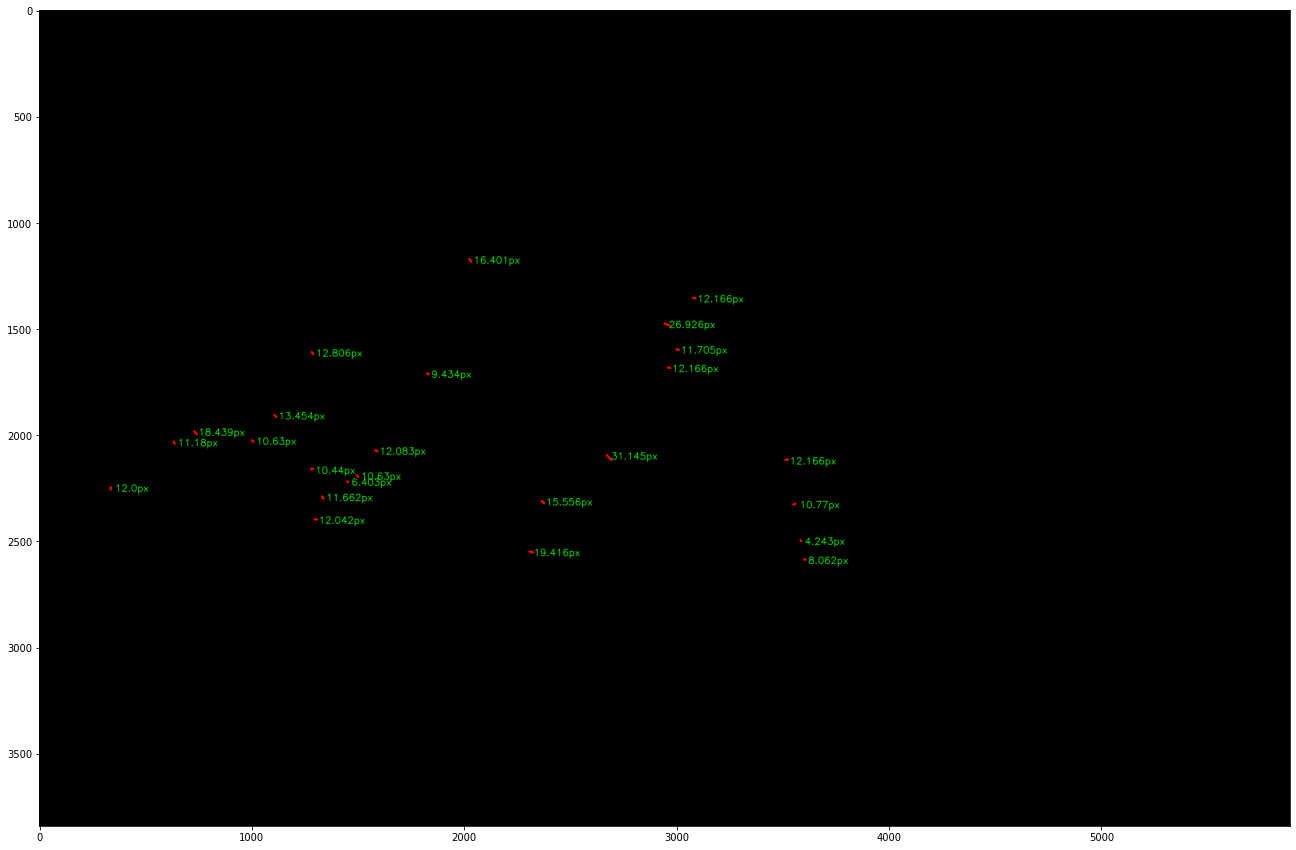

In [ ]:
cracklines = get_crack_lines(IMAGE_TO_PLOT)
cracklines_with_text = put_text(cracklines)
plt.figure(figsize=(25, 15))
plt.imshow(cracklines_with_text)

# plt.savefig("cracklines_with_text.png")

In [ ]:
rgb = cv2.cvtColor(IMAGE_TO_PLOT * 255, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
mask_crackline = cv2.addWeighted(rgb, 0.3, cracklines_with_text, 1,0)


plt.figure(figsize=(25, 15))
plt.imshow(mask_crackline)

TypeError: ignored

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + cracklines)

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + mask_crackline)


In [ ]:
boundary = get_boundary(IMAGE_TO_PLOT, (255,0,0))

plt.figure(figsize=(25, 15))
plt.imshow(cracklines + img_resized + boundary, cmap="gray")

##  UNET

In [ ]:
IMAGE_TO_PLOT = unet_no_noise

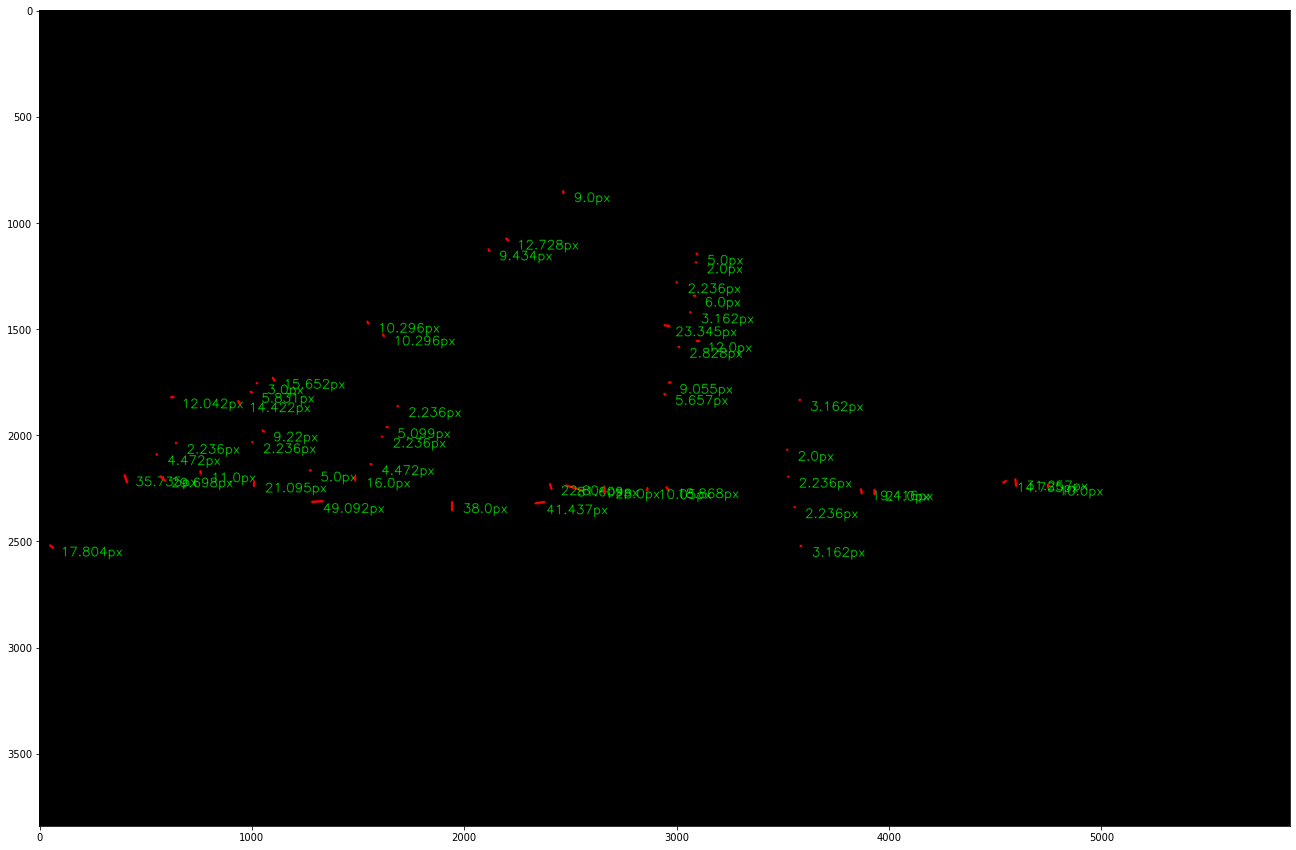

In [ ]:
cracklines = get_crack_lines(IMAGE_TO_PLOT)
plt.figure(figsize=(25, 15))
plt.imshow(cracklines)

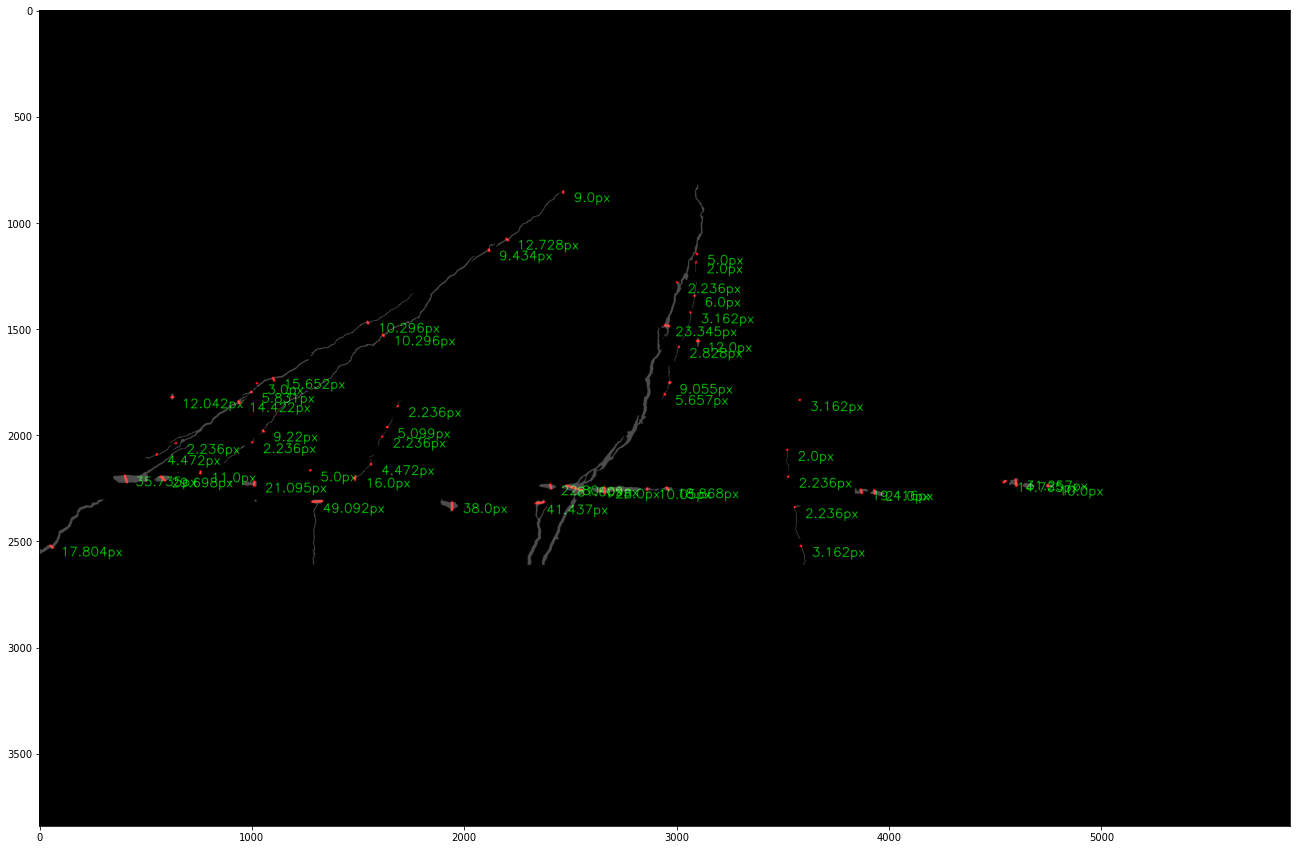

In [ ]:
mask_crackline = blend_crackline_w_mask(cracklines, IMAGE_TO_PLOT, 0.3, 1)
plt.figure(figsize=(25, 15))
plt.imshow(mask_crackline)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


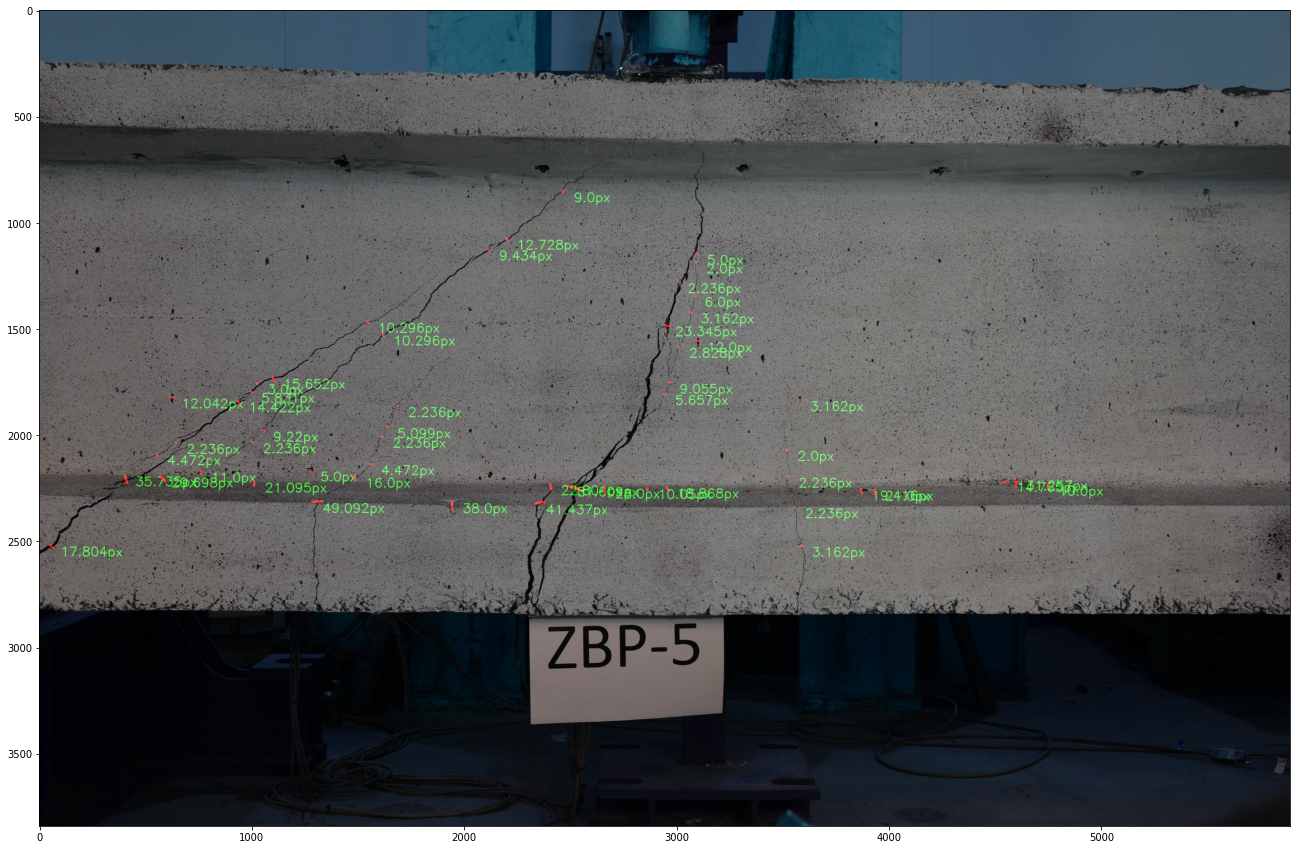

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + cracklines)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


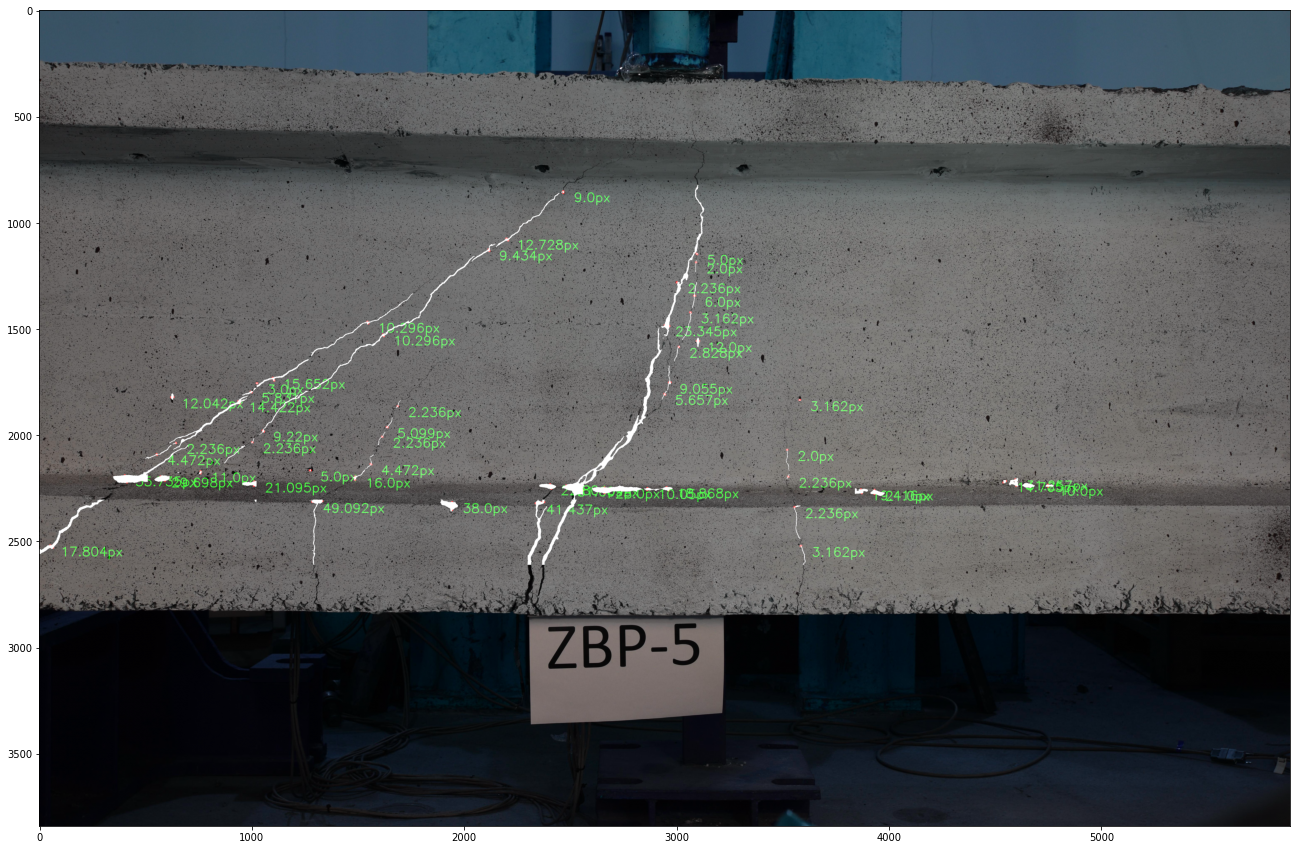

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + mask_crackline)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


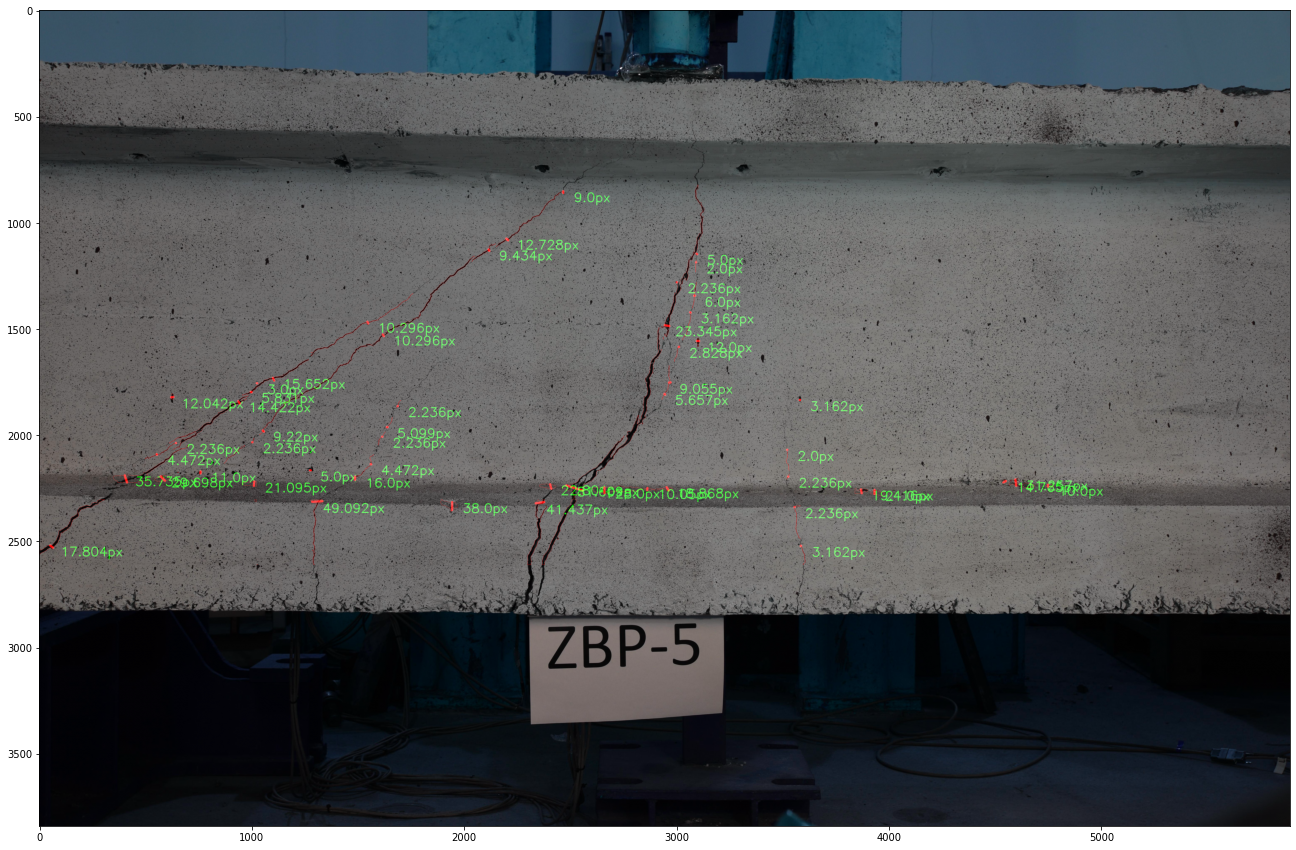

In [ ]:
boundary = get_boundary(IMAGE_TO_PLOT, (255,0,0))

plt.figure(figsize=(25, 15))
plt.imshow(cracklines + img_resized + boundary, cmap="gray")

In [ ]:
IMAGE_TO_PLOT = attunet_no_noise

In [ ]:
cracklines = get_crack_lines(IMAGE_TO_PLOT)
plt.figure(figsize=(25, 15))
plt.imshow(cracklines)

In [ ]:
mask_crackline = blend_crackline_w_mask(cracklines, IMAGE_TO_PLOT, 0.3, 1)
plt.figure(figsize=(25, 15))
plt.imshow(mask_crackline)

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + cracklines)

In [ ]:
plt.figure(figsize=(25, 15))
plt.imshow(img_resized + mask_crackline)

In [ ]:
boundary = get_boundary(IMAGE_TO_PLOT, (255,0,0))

plt.figure(figsize=(25, 15))
plt.imshow(cracklines + img_resized + boundary, cmap="gray")